# Visualização dos dados dos experimentos
Nesse notebook visualizamos os dados obtidos em filmagens dos experimentos de Queda Livre, Rampa Inclinada e Pêndulo

In [1]:
#importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.CRITICAL)

## 1. Importação dos dados
Primeiramente abrimos os dados salvos em csv para cada um dos experimentos. Para isso vamos utilizar a biblioteca pandas, muito usada para manipulação de dados em csv. A biblioteca cria um objeto DataFrame, que possui vários métodos de manipulação. Os csv possuem em comum as coluna "time", "angle" ou "position" que representa a posição e "experiment" que indica de qual filmagem se trata o dado.

In [2]:
dfQuedaLivre = pd.read_csv('DATA/freeFall.csv')
dfPendulo = pd.read_csv('DATA/pendulum.csv')
dfAtrito= pd.read_csv('DATA/atrito.csv')
#colocar o "270" em 0
dfPendulo['angle'] = 270 - dfPendulo['angle']

Dados do Pêndulo:

In [3]:
dfPendulo.head()

,time,angle,experiment
0,0.0021,9.0,1
1,0.0708,8.2,1
2,0.1396,6.0,1
3,0.2083,3.0,1
4,0.2771,-0.5,1


Dados da Queda Livre:

In [4]:
dfQuedaLivre.head()

,time,position,experiment
0,0.0000,0.006,1
1,0.0187,0.009,1
2,0.0375,0.014,1
3,0.0562,0.023,1
4,0.0750,0.035,1


Dados da Rampa:

In [5]:
dfAtrito.head()

,time,position,bar_height,experiment
0,0.033,0.192,0.166,1
1,0.067,0.192,0.166,1
2,0.100,0.192,0.166,1
3,0.133,0.193,0.166,1
4,0.167,0.196,0.166,1


## 2. Visualização dos dados
### 2.1 Criação das funções de visualização
Após importar os dados vamos criar uma função genéria que plot gráficos de uma coluna do DataFrame em função do tempo. A função plotCol recebe como argumentos o DataFrame, os nomes dos eixos, a coluna a ser visualizada, o título do gráfico, as filmagens a serem observadas e dois booleanos que indicam se devemos plotar a média dos valores e uma reta de ajuste dos valores.

In [6]:
def plotCol(df, xlabel, ylabel, colName, titleName, experiments, titleCol, plotMean = True, plotFit = False):
    #experiments = df['experiment'].unique()
    velMeans = []
    dirname = './img/vis/'

    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]
        x = dff.time
        y = dff[colName]
        velMeans.append(y.mean())        
        
        plt.title(f'{titleCol} na filmagem {ex} ({titleName})')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)


        plt.scatter(x, y, c = 'tab:orange', zorder = 2)
        
        if(plotFit) :
            idx = np.isfinite(x) & np.isfinite(y)
            m, b = np.polyfit(x[idx], y[idx], 1)
            plt.plot(x, y, zorder = 1)
            plt.plot(x, m*x + b, label = "Reta ajustada", linestyle = "--", zorder = 3, c = 'r')
            plt.legend()
        else:
            plt.plot(x, y, zorder = 1)

 
        figname = titleName + '-' + titleCol + '-' + str(ex) + '.png'
        figname = figname.lower().replace(' ', '-').replace('ã', 'a').replace('ç', 'c').replace('ê', 'e')
        figname = dirname + figname
        plt.savefig(figname)
        plt.show()
        
                
    if(plotMean):
        velMeans = np.array(velMeans)

        fig, axs = plt.subplots()    
        
        axs.scatter(experiments, velMeans, label = 'Média no Experimento')
        axs.set_xlabel('Filmagem')
        axs.set_ylabel(f'Média da {ylabel}')
        axs.set_xticks(experiments)
        axs.set_title(f'Média da {ylabel} em cada filmagem ({titleName})')
        axs.axhline(y = np.mean(velMeans), linestyle = '--', label = 'Média das Médias')
        s = "{:.2f}".format(np.mean(velMeans))
        trans = transforms.blended_transform_factory(axs.get_yticklabels()[0].get_transform(), axs.transData)
        axs.text(0,np.mean(velMeans), s, color="red", transform=trans, ha="right", va="center")
        axs.legend()
        figname = 'media-' + titleName + '-' + titleCol + '.png'
        figname = figname.lower().replace(' ', '-').replace('ã', 'a').replace('ç', 'c').replace('ê', 'e')
        figname = dirname + figname
        plt.savefig(figname)
        plt.show()

### 2.2 Criação das colunas de velocidade e aceleração
Com essas funções acrescentamos as colunas de velocidade e aceleração em cada instante ao DataFrama utilizando a seguinte expressão:
$$v_e(t_i) = \frac{x_e(t_{i+1} - x_e(t_i))}{t_{i+1} - t_i}$$
Fazemos o equivalente com a aceleração após calcular a velocidade. Perceba que a função escrita acima também é útil para visualizar esses parâmetros.

In [7]:
def createVelCol(df, positionName):
    velocities = []
    experiments = df['experiment'].unique()
    
    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]
        
        indices = list(dff.index.values)
        indices.pop()
        
        for i in indices:
            v = (dff[positionName][i+1] - dff[positionName][i]) / (dff.time[i+1] - dff.time[i])
            velocities.append(v)
        
        velocities.append(np.nan)
        
    df['velocity'] = velocities
            

def createAccCol(df):
    accs = []
    experiments = df['experiment'].unique()

    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]

        indices = list(dff.index.values)
        indices.pop()
        indices.pop()

        for i in indices:
            a = (dff['velocity'][i+1] - dff['velocity'][i]) / (dff.time[i+1] - dff.time[i])
            accs.append(a)

        accs.append(np.nan)
        accs.append(np.nan)

    df['acceleration'] = accs


Agora rodamos as funções que escrevemos acima para adicionar as colunas 'velocity' e 'acc' ao DataFrame.

In [8]:
createVelCol(dfQuedaLivre, 'position')
createAccCol(dfQuedaLivre)

createVelCol(dfPendulo, 'angle')
createAccCol(dfPendulo)

createVelCol(dfAtrito, 'position')
createAccCol(dfAtrito)

## 3. Visualização dos Dados
Para cada movimento escolhemos quais filmagens queremos visualizar.

In [9]:
obsQuedaLivre = [1,2,3,4,5]
obsPendulo = [1,2,3,4,5]
obsAtrito = [3,4,5,6,8]

### 3.1 Posição
Rodamos a função plotCol para cada DataFrame para visualizar a posição em cada experimento.

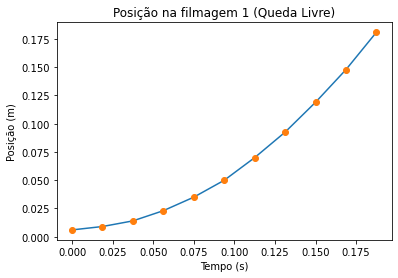

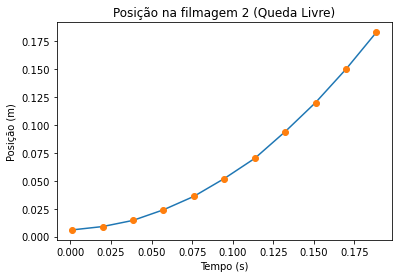

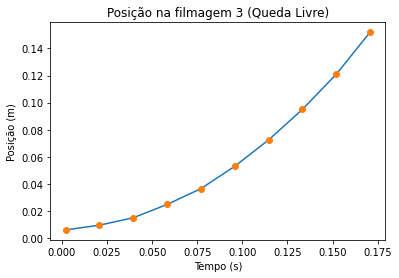

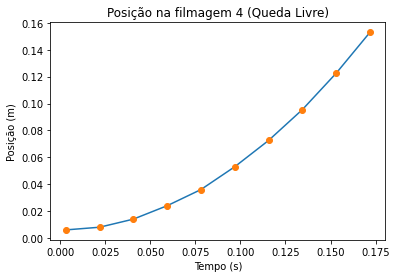

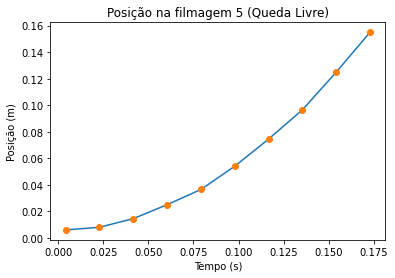

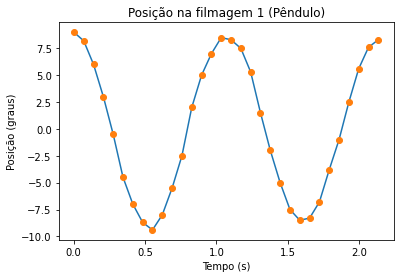

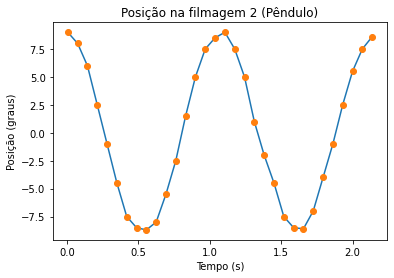

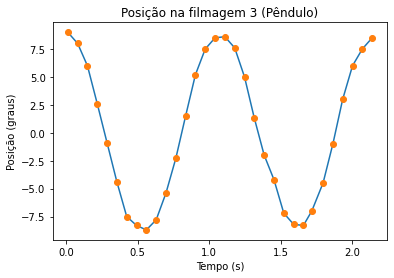

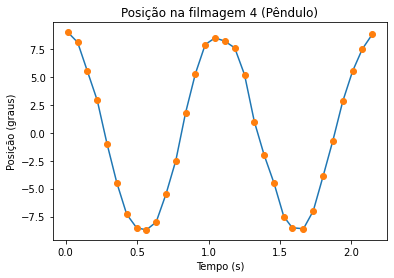

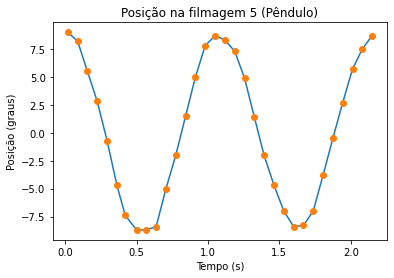

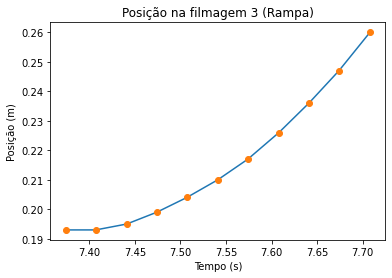

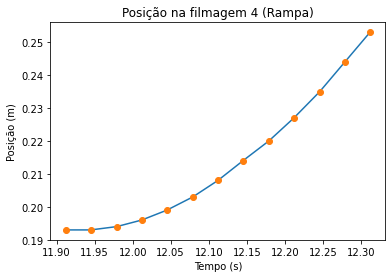

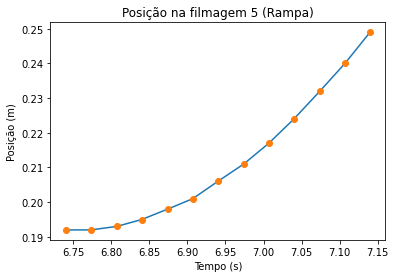

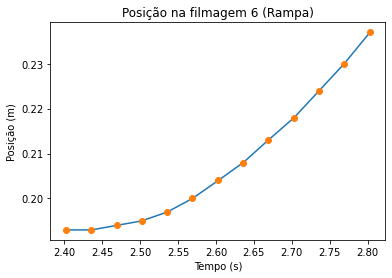

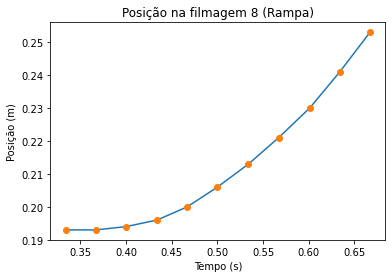

In [10]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Posição (m)', 'position', 'Queda Livre', obsQuedaLivre, "Posição", False)
plotCol(dfPendulo, 'Tempo (s)', 'Posição (graus)', 'angle', 'Pêndulo', obsPendulo, "Posição", False)
plotCol(dfAtrito, 'Tempo (s)', 'Posição (m)', 'position', 'Rampa', obsAtrito, "Posição", False)

### 3.2 Velocidade
Aqui visualizamos a velocidade em cada experimento. Perceba que para Queda Livre e Rampa também plotamos a reta ajustada aos valores para um melhor entendimento dos gráficos. Além disso, plotamos a média das médias de cada filmagem para cada experimento.

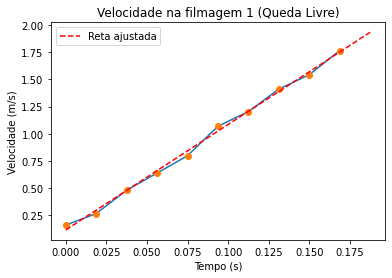

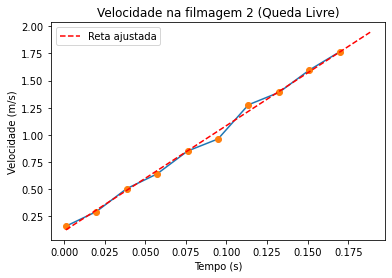

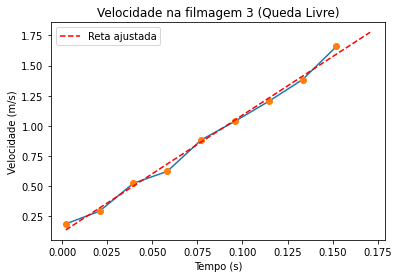

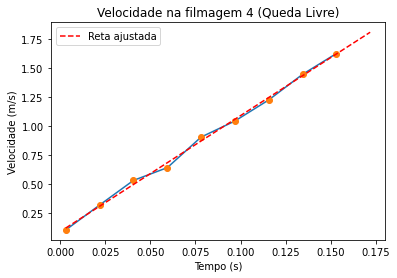

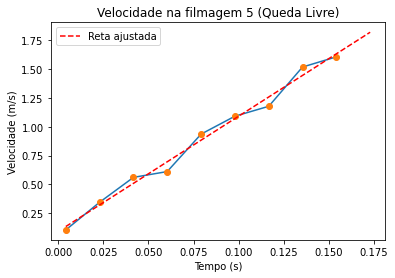

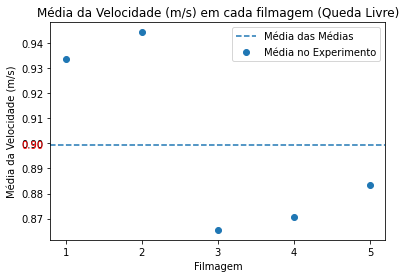

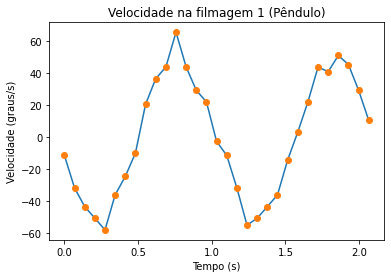

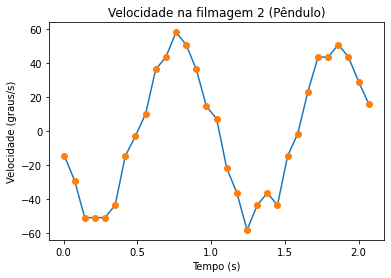

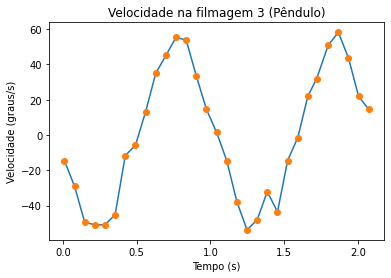

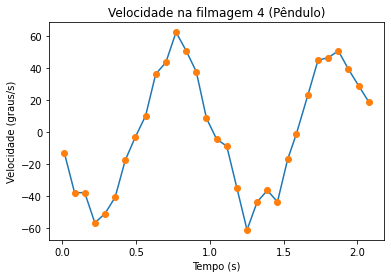

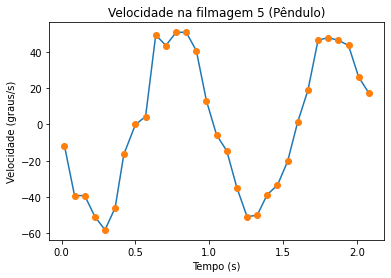

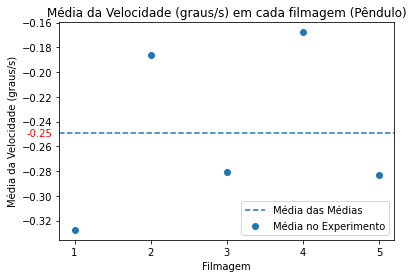

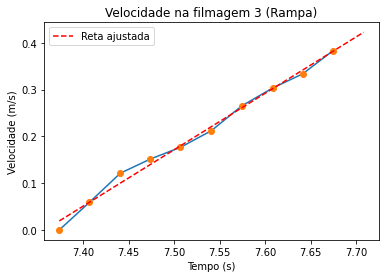

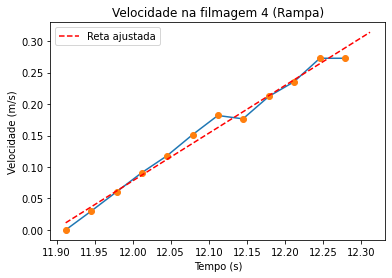

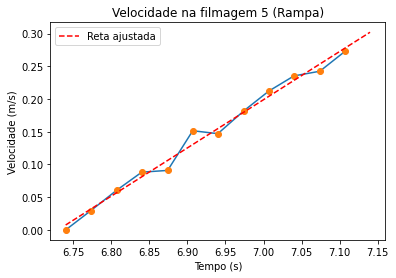

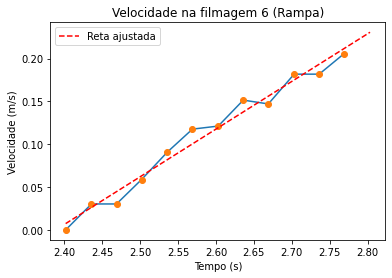

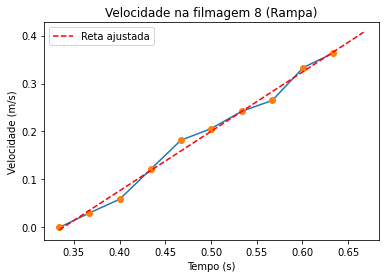

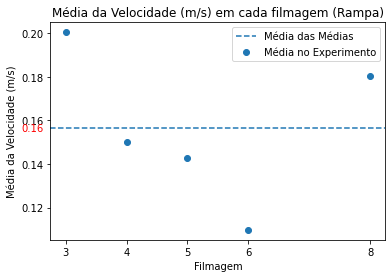

In [11]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Queda Livre', obsQuedaLivre, 'Velocidade', plotFit = True)
plotCol(dfPendulo, 'Tempo (s)', 'Velocidade (graus/s)', 'velocity', 'Pêndulo', obsPendulo, 'Velocidade')
plotCol(dfAtrito, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Rampa', obsAtrito, 'Velocidade', plotFit = True)

### 3.3 Aceleração
Finalmente, plotamos a aceleração e as médias.

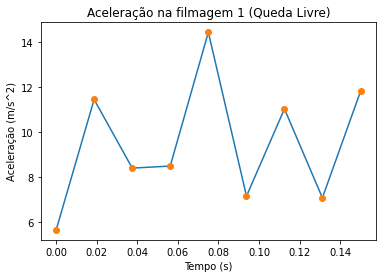

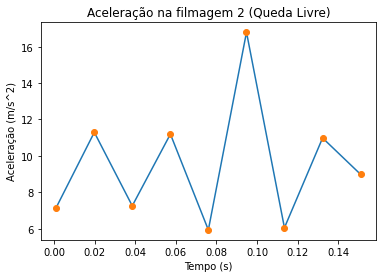

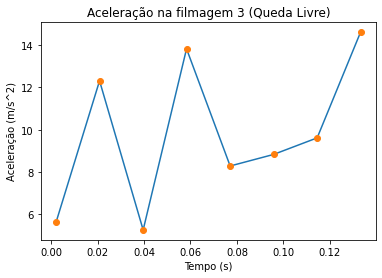

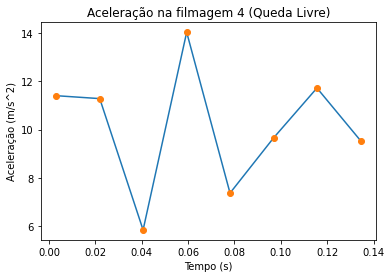

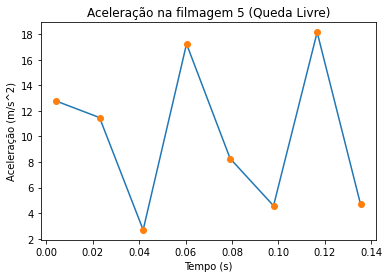

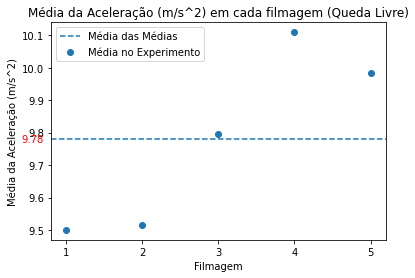

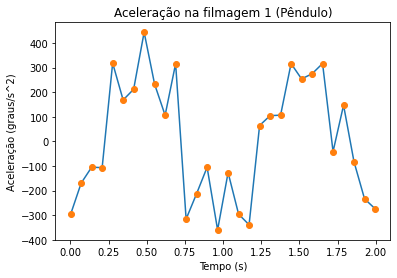

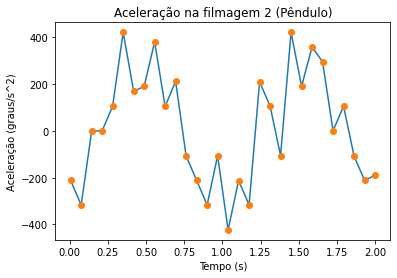

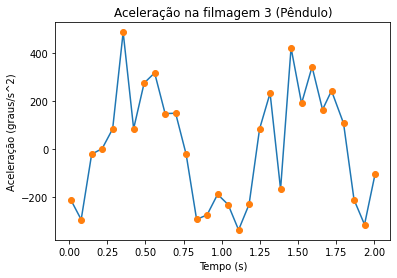

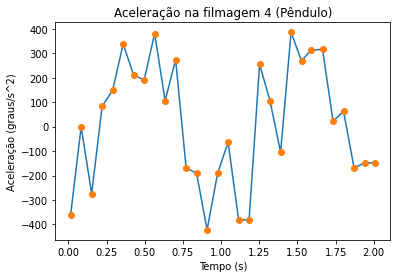

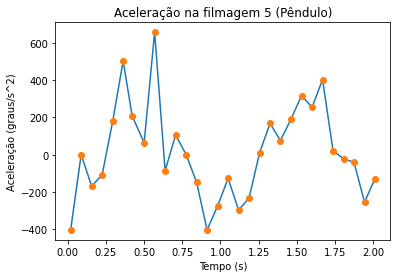

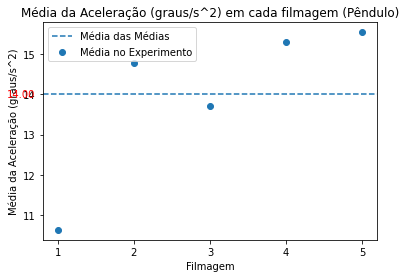

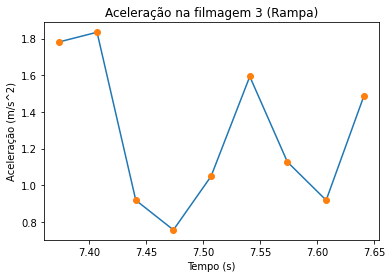

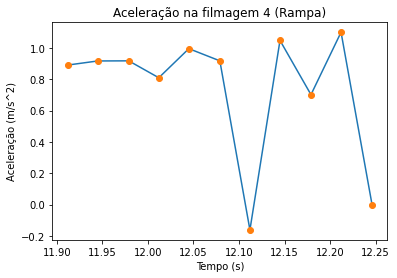

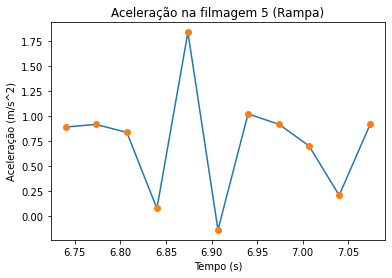

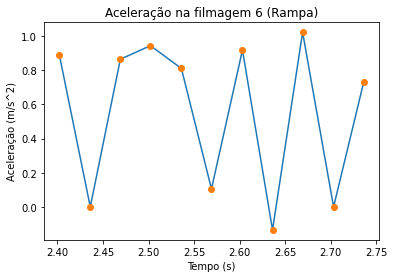

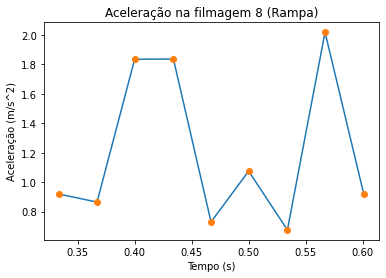

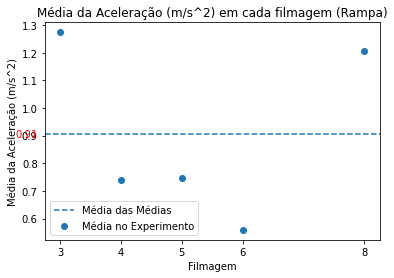

In [12]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Queda Livre', obsQuedaLivre, 'Aceleração')
plotCol(dfPendulo, 'Tempo (s)', 'Aceleração (graus/s^2)', 'acceleration', 'Pêndulo', obsPendulo, 'Aceleração', )
plotCol(dfAtrito, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Rampa', obsAtrito, 'Aceleração') 

## 4. Salvando os Dados
Para efeito de comparação com a simulação, vamos salvar os DataFrames com as colunas de velocidade e aceleração em csv.

In [13]:
dfQuedaLivre.to_csv('DATA/ffWVel.csv', index = False)
dfPendulo.to_csv('DATA/pWVel.csv', index = False)
dfAtrito.to_csv('DATA/aWVel.csv', index = False)

## 5. Unit tests
Criamos uma classe para testar todas as funções que não são de plot.

In [14]:
import unittest
class TestNotebook(unittest.TestCase):
    
    def test_createVelCol(self):
        d = {'position':[2,4,8],
             'time' : [0,1,2],
             'experiment' : 1}
        
        df = pd.DataFrame(d)
        
        vel = [2.0, 4.0, np.NaN]
        createVelCol(df, 'position')
                
        vel2 = df['velocity'].to_numpy()
        
        self.assertEqual(2.0, vel[0])
        self.assertEqual(4.0, vel[1])
        self.assertTrue(np.isnan(vel[2]))
    
    def test_createAccCol(self):
        d = {
            'velocity': [2,4,8],
            'time': [0,1,2],
            'experiment' : 1
        }

        df = pd.DataFrame(d)

        acc = [2.0, 4.0, np.NaN]
        createAccCol(df)
        
        self.assertEqual(2.0, acc[0])
        self.assertEqual(4.0, acc[1])
        self.assertTrue(np.isnan(acc[2]))        
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_createAccCol (__main__.TestNotebook) ... ok
test_createVelCol (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK
